# Bike Sharing Demand

https://www.kaggle.com/c/bike-sharing-demand

- 문제 소개 
- 데이터 간략 설명 
- Exploratory Data Analysis (EDA) & 데이터 시각화 
- 베이스라인 
- 모델 업그레이드 

## 문제 소개 

- Regression : 시간별 자전거 대여 수량 예측 
  - casual : 등록되지 않은 사용자(비회원) 수  
  - registered : 등록된 사용자(회원) 수 
  - count : 자전거 대여 수량 
- play ground competition 
  - 비교적 난이도가 낮은 연습용 대회 
  - 상금과 메달은 없지만 티셔츠나 머그잔 같은 상품 

## 데이터 

- 2011~2012 2년간 자전거 대여 데이터 
- 캐피털 바이크셰어 회사가 공개한 운행 기록 + 날씨정보
- 한 시간 간격의 대여 데이터 
- 학습 : 매달 1~19일까지의 기록 
- 테스트 : 매달 20~월말까지의 기록 

## EDA

In [1]:
from datetime import datetime 

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib as mpl
from matplotlib import pyplot as plt 

%matplotlib inline 

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_submission = pd.read_csv("data/sampleSubmission.csv")

In [3]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
df_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [6]:
df_test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [7]:
df_submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


### 가설 세우기 (언제 따릉이를 많이 탈까?)

- 날씨
  - 비오는 날 보단 해 있는 날 
  - 너무 덥거나 추운날 보단 적당한 날 
  - 습도가 너무 높은 날은 별로 안 탈 것 
  - 바람이 너무 많이 불면 별로 안 탈 것 
- 시간
  - 평일 보다는 공휴일에 많이 탈 것 
  - 새벽시간에는 별로 안 탈 것 
  - 같은 요일 대여량이 비슷하지 않을까? (저번주 월요일과 이번주 월요일의 대여량)

### 주의 해야할 사항 (시간에 관련된 데이터를 다룰 때)
- 1월(31일), 2월(28일 or 29일)에 따른 총 대여 개수 차이 
- 데이터 제공시 GMT+0 으로 제공할 수 있기 때문에 국가별 타임존 고려 (ex. 한국(GMT+9), 독일(GMT+1))

In [8]:
pd.to_datetime(df_train["datetime"]).dt.weekday

0        5
1        5
2        5
3        5
4        5
        ..
10881    2
10882    2
10883    2
10884    2
10885    2
Name: datetime, Length: 10886, dtype: int64

In [9]:
df_train["datetime"] = pd.to_datetime(df_train["datetime"])
df_test["datetime"] = pd.to_datetime(df_test["datetime"])
for attr in ["year", "month", "day", "hour", "minute", "second", "weekday"]:
    df_train[attr] = getattr(df_train["datetime"].dt, attr)
    df_test[attr] = getattr(df_test["datetime"].dt, attr)

In [10]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [11]:
idx2season = {1 : "Spring", 2 : "Summer", 3 : "Fall", 4 : "Winter"}
idx2weather = {1 : "Clear", 2 : "Mist, Few clouds", 3 : "Light Snow, Rain, Thunderstorm", 4 : "Heavy Rain, Thunderstorm, Snow, Fog"}
df_train["season"] = df_train["season"].map(idx2season)
df_train["weather"] = df_train["weather"].map(idx2weather)

In [12]:
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0,1,Clear,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,0,0,2
10882,2012-12-19 20:00:00,Winter,0,1,Clear,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,0,0,2
10883,2012-12-19 21:00:00,Winter,0,1,Clear,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,0,0,2
10884,2012-12-19 22:00:00,Winter,0,1,Clear,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,0,0,2


## 데이터 시각화 

- 타겟값을 그대로 사용할 것인가
- 회귀에서 좋은 성능을 내려면 타겟값이 정규분포를 따르는 것이 좋다 

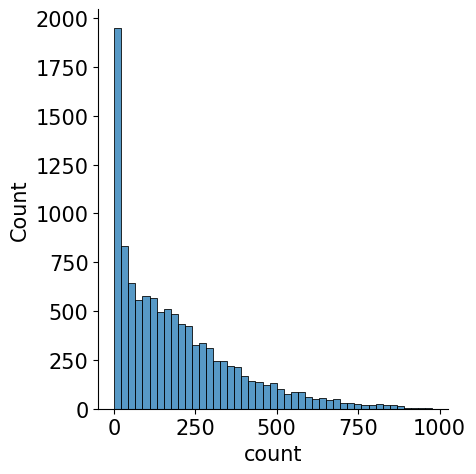

In [13]:
mpl.rc("font", size=15)
sns.displot(df_train["count"])

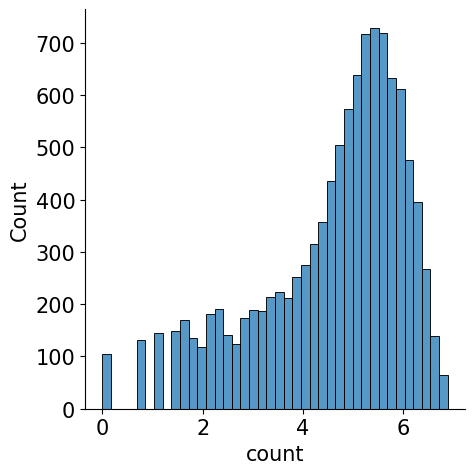

In [14]:
mpl.rc("font", size=15)
sns.displot(np.log(df_train["count"]))

- y를 그대로 예측하는 것이 아닌 log(y)를 예측하고 후에 exp로 복원 
- $y=e^{log(y)}$

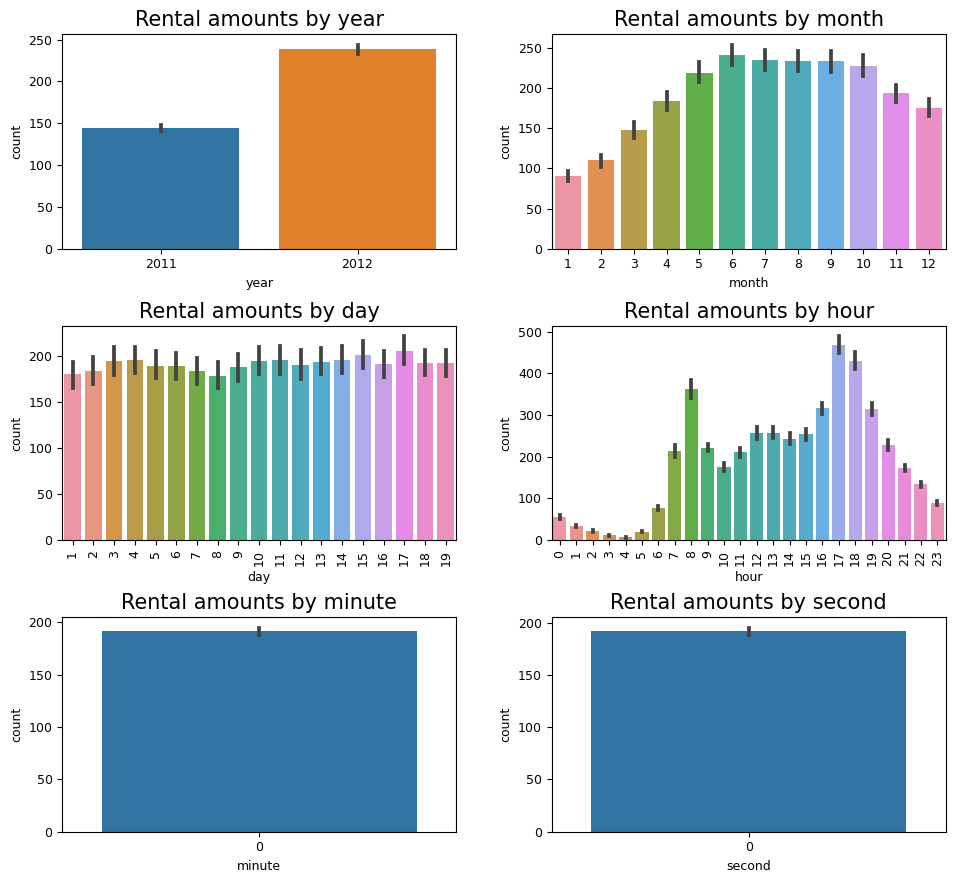

In [15]:
nrows=3
ncols=2
mpl.rc("font", size=9)
mpl.rc("axes", titlesize=15)
figure, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.tight_layout()
figure.set_size_inches(10, 9)
for idx, attr in enumerate(["year", "month", "day", "hour", "minute", "second"]):
    i = idx // ncols
    j = idx % ncols
    sns.barplot(data=df_train, x=attr, y="count", ax=axes[i, j])
    axes[i, j].set(title=f"Rental amounts by {attr}")
    if i == 1:
        axes[i, j].tick_params(axis="x", labelrotation=90)

- day, minute, second 제거 

- boxplot
  - 여러 데이터 분포를 한 눈에 보고 비교할 때 사용 
  - q1(0.25), q2(0.5), q3(0.75)
  - iqr(interquartile range) = q3 - q1 
  - max = q3 + 1.5*iqr
  - min = q1 - 1.5*iqr
  - outlier : min, max를 벗어나는 데이터 

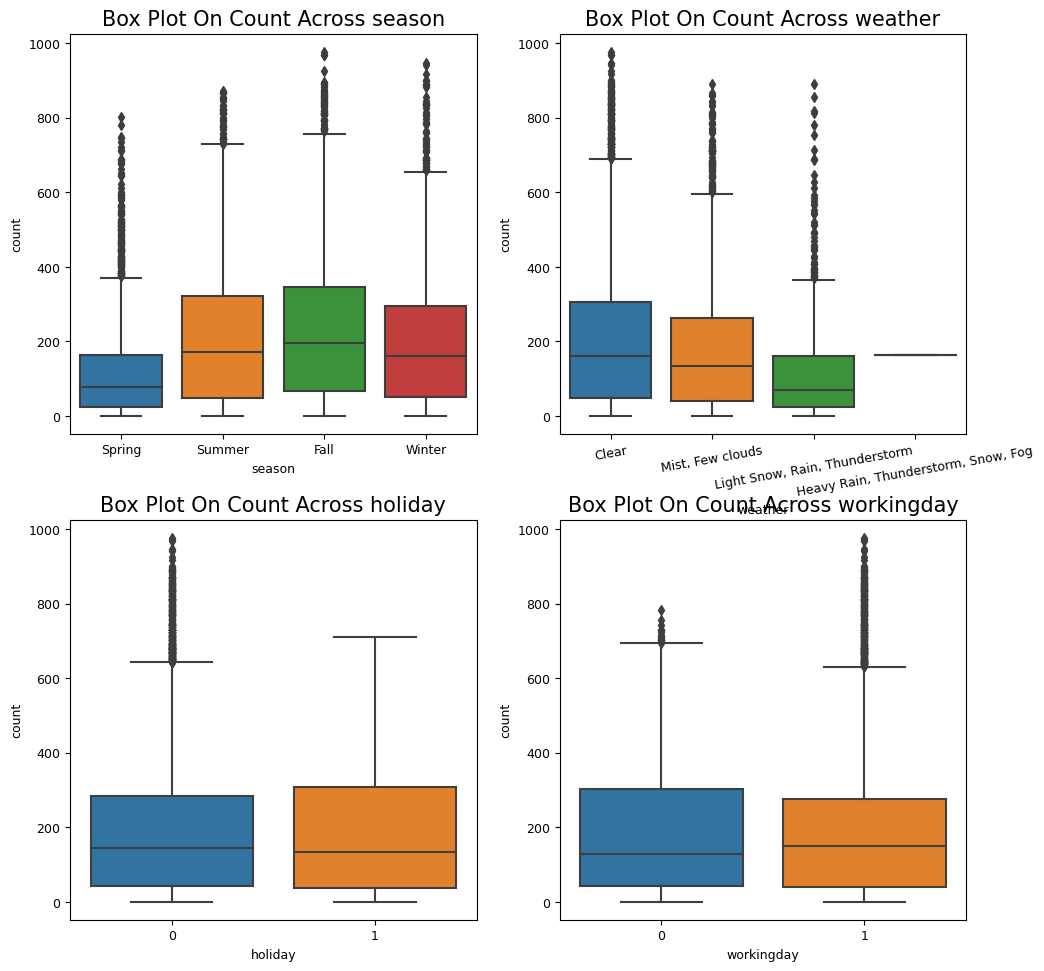

In [16]:
nrows=2
ncols=2
figure, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.tight_layout()
figure.set_size_inches(10, 10)
for idx, attr in enumerate(["season", "weather", "holiday", "workingday"]):
    i = idx // ncols
    j = idx % ncols
    sns.boxplot(data=df_train, x=attr, y="count", ax=axes[i, j])
    axes[i, j].set(title=f"Box Plot On Count Across {attr}")
    if i == 0 and j == 1:
        axes[i, j].tick_params(axis="x", labelrotation=10)

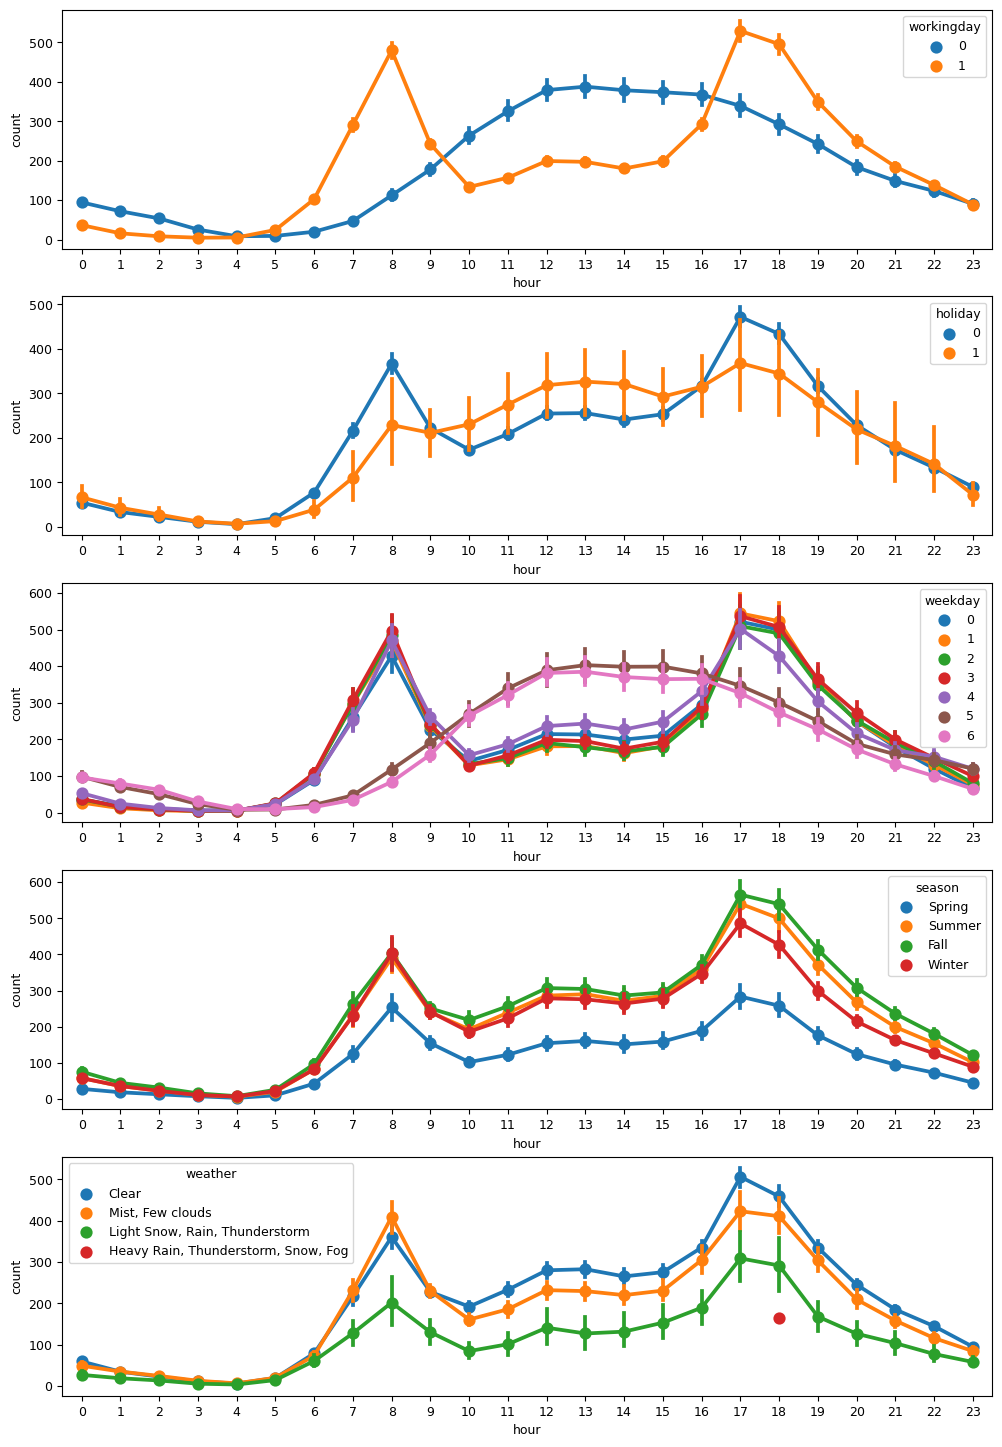

In [17]:
nrows=5
figure, axes = plt.subplots(nrows=nrows)
figure.set_size_inches(12, 18)
for i, hue in enumerate(["workingday", "holiday", "weekday", "season", "weather"]):
    sns.pointplot(data=df_train, x="hour", y="count", hue=hue, ax=axes[i]) # hue : 컬러를 나누는 기준 

- weather = 4 제거 

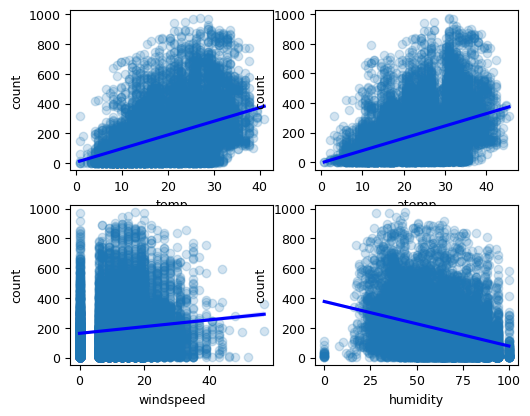

In [18]:
nrows=2
ncols=2
figure, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.tight_layout()
figure.set_size_inches(5, 4)
for idx, attr in enumerate(["temp", "atemp", "windspeed", "humidity"]):
    i = idx // ncols
    j = idx % ncols
    sns.regplot(data=df_train, x=attr, y="count", ax=axes[i, j], scatter_kws={'alpha':0.2}, line_kws={"color":"blue"})

- windspeed가 0인 데이터가 많음. 결측치거나 오류

In [19]:
df_train[["temp", "atemp", "windspeed", "humidity"]].corr()

,temp,atemp,windspeed,humidity
temp,1.000000,0.984948,-0.017852,-0.064949
atemp,0.984948,1.000000,-0.057473,-0.043536
windspeed,-0.017852,-0.057473,1.000000,-0.318607
humidity,-0.064949,-0.043536,-0.318607,1.000000


[Text(0.5, 1.0, 'Heatmap of Numerical Data')]

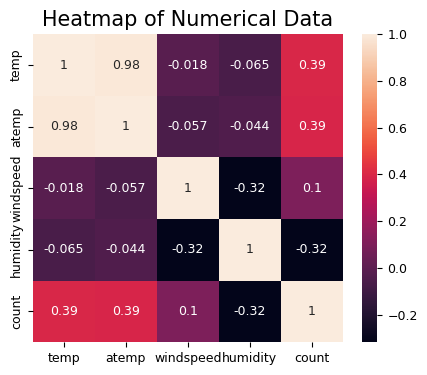

In [20]:
corrMat = df_train[["temp", "atemp", "windspeed", "humidity", "count"]].corr()
fig, ax = plt.subplots()
fig.set_size_inches(5, 4)
sns.heatmap(corrMat, annot=True)
ax.set(title="Heatmap of Numerical Data")

### EDA에 따른 Feature Engineering 요약 
- target 값 변환 : $y=e^{log(y)}$
- feature 추가 
  - datetime -> year, month, day, hour, minute, second, weekday 
- feature 제거 
  - testset 에 없는 casual, registered 제거 
  - datetime (날짜 요소들로 변환 했으므로)
  - day, minute, second 제거 
  - windspeed 제거 
- 이상치 제거 
  - weather = 4 제거